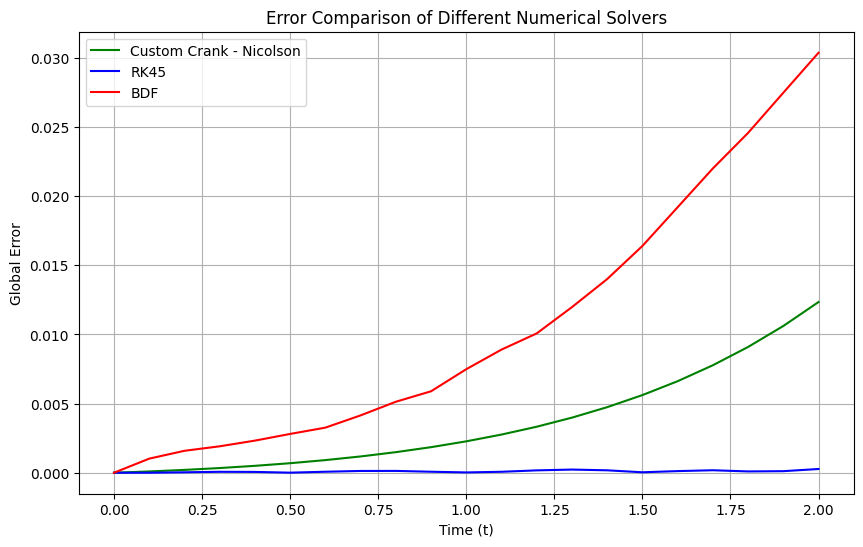

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import brainstate
import brainunit as u
from scipy.integrate import solve_ivp

def newton_method(f, y0, t, dt, tol=1e-5, max_iter=100, order = 2, args=()):
    def g_1(t, y, *args):
        return y - y0 - dt * f(t + dt, y, *args)

    def g_2(t, y, *args):
        return y - y0 - 0.5 * dt * (f(t, y0, *args) + f(t + dt, y, *args))

    def g(t, y, *args):
        branches = [g_1, g_2]
        index = jnp.clip(order - 1, 0, 1)
        return jax.lax.switch(index, branches, t, y, *args)

    def cond_fun(carry):
        i, y1, A, df = carry
        condition = jnp.logical_or(jnp.linalg.norm(A) < tol, jnp.linalg.norm(df) < tol)
        return jnp.logical_and(i < max_iter, jnp.logical_not(condition))

    def body_fun(carry):
        i, y1, _, _ = carry
        A, df = brainstate.augment.jacfwd(lambda y: g(t, y, *args), return_value=True, has_aux=False)(y1)
        new_y1 = y1 - jnp.linalg.solve(A, df)
        return (i + 1, new_y1, A, df)
    
    dt = u.get_magnitude(dt)
    A, df= brainstate.augment.jacfwd(lambda y: g(t, y, *args), return_value=True, has_aux=False)(y0)
    init_carry = (0, y0, A, df)
    _, result, _, _ = jax.lax.while_loop(cond_fun, body_fun, init_carry)
    return result

def f(t, y):
    return y

y0 = jnp.array([1.0])
t_start = 0.0
t_end = 2.0
dt = 0.1
num_steps = int((t_end - t_start) / dt)
t_values = jnp.linspace(t_start, t_end, num_steps + 1)

y_numerical = [y0]
y_current = y0
for i in range(num_steps):
    t = t_values[i]
    y_current = newton_method(f, y_current, t, dt, order= 2)
    y_numerical.append(y_current)
y_numerical = jnp.array(y_numerical).flatten()

y_true = jnp.exp(t_values)

custom_errors = jnp.abs(y_true - y_numerical)

# 使用 scipy 的 RK45 方法求解
sol_rk45 = solve_ivp(f, [t_start, t_end], y0, t_eval=t_values, method='RK45')
y_rk45 = sol_rk45.y.flatten()
rk45_errors = jnp.abs(y_true - y_rk45)

# 使用 scipy 的 BDF 方法求解
sol_bdf = solve_ivp(f, [t_start, t_end], y0, t_eval=t_values, method='BDF')
y_bdf = sol_bdf.y.flatten()
bdf_errors = jnp.abs(y_true - y_bdf)

# 绘制误差比较曲线
plt.figure(figsize=(10, 6))
plt.plot(t_values, custom_errors, label='Custom Crank - Nicolson', color='green')
plt.plot(t_values, rk45_errors, label='RK45', color='blue')
plt.plot(t_values, bdf_errors, label='BDF', color='red')
plt.xlabel('Time (t)')
plt.ylabel('Global Error')
plt.title('Error Comparison of Different Numerical Solvers')
plt.legend()
plt.grid(True)
plt.show()

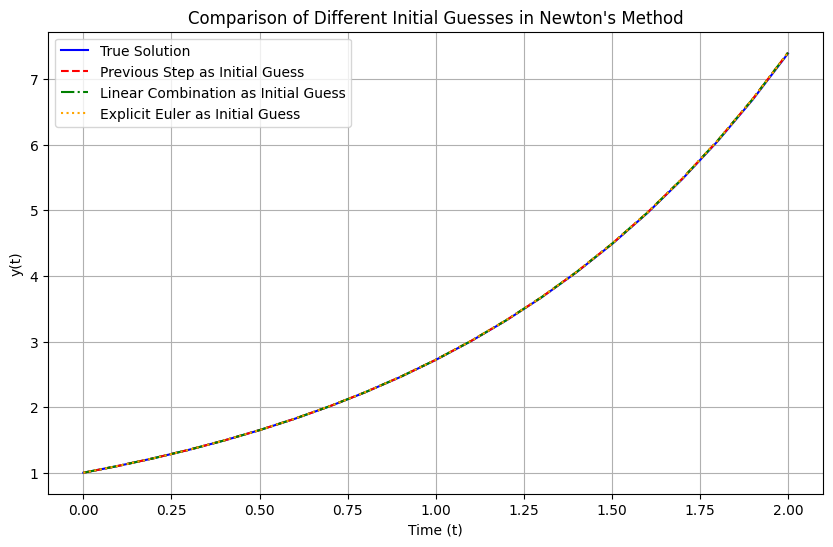

In [ ]:

def newton_method(f, y0, t, dt, tol=1e-5, max_iter=100, args=(), init_guess=None):
    def g(t, y, *args):
        return y - y0 - 0.5 * dt * (f(t, y0, *args) + f(t + dt, y, *args))

    def cond_fun(carry):
        i, y1, A, df = carry
        condition = jnp.logical_or(jnp.linalg.norm(A) < tol, jnp.linalg.norm(df) < tol)
        return jnp.logical_and(i < max_iter, jnp.logical_not(condition))

    def body_fun(carry):
        i, y1, _, _ = carry
        jac_fun = jax.jacfwd(lambda y: g(t, y, *args))
        A = jac_fun(y1)
        df = g(t, y1, *args)
        new_y1 = y1 - jnp.linalg.solve(A, df)
        return (i + 1, new_y1, A, df)

    if init_guess is None:
        y1 = y0
    else:
        y1 = init_guess

    jac_fun = jax.jacfwd(lambda y: g(t, y, *args))
    A = jac_fun(y1)
    df = g(t, y1, *args)
    init_carry = (0, y1, A, df)
    _, result, _, _ = jax.lax.while_loop(cond_fun, body_fun, init_carry)
    return result


def f(t, y):
    return y

y0 = jnp.array([1.0])
t_start = 0.0
t_end = 2.0
dt = 0.1
num_steps = int((t_end - t_start) / dt)
t_values = jnp.linspace(t_start, t_end, num_steps + 1)

# 使用上一步的值作为初始猜测
y_numerical_prev = [y0]
y_current = y0
for i in range(num_steps):
    t = t_values[i]
    y_current = newton_method(f, y_current, t, dt)
    y_numerical_prev.append(y_current)
y_numerical_prev = jnp.array(y_numerical_prev).flatten()

# 使用前两步值的线性组合作为初始猜测
y_numerical_linear = [y0]
y_current = y0
y_prev = y0
alpha = 0.5
for i in range(num_steps):
    t = t_values[i]
    if i > 0:
        init_guess = alpha * y_prev + (1 - alpha) * y_current
    else:
        init_guess = y_current
    y_prev = y_current
    y_current = newton_method(f, y_current, t, dt, init_guess=init_guess)
    y_numerical_linear.append(y_current)
y_numerical_linear = jnp.array(y_numerical_linear).flatten()

# 使用显式欧拉法下一步的值作为初始猜测
y_numerical_euler = [y0]
y_current = y0
for i in range(num_steps):
    t = t_values[i]
    init_guess = y_current + dt * f(t, y_current)
    y_current = newton_method(f, y_current, t, dt, init_guess=init_guess)
    y_numerical_euler.append(y_current)
y_numerical_euler = jnp.array(y_numerical_euler).flatten()


y_true = jnp.exp(t_values)

plt.figure(figsize=(10, 6))
plt.plot(t_values, y_true, label='True Solution', color='blue')
plt.plot(t_values, y_numerical_prev, label='Previous Step as Initial Guess', color='red', linestyle='--')
plt.plot(t_values, y_numerical_linear, label='Linear Combination as Initial Guess', color='green', linestyle='-.')
plt.plot(t_values, y_numerical_euler, label='Explicit Euler as Initial Guess', color='orange', linestyle=':')
plt.xlabel('Time (t)')
plt.ylabel('y(t)')
plt.title('Comparison of Different Initial Guesses in Newton\'s Method')
plt.legend()
plt.grid(True)
plt.show()

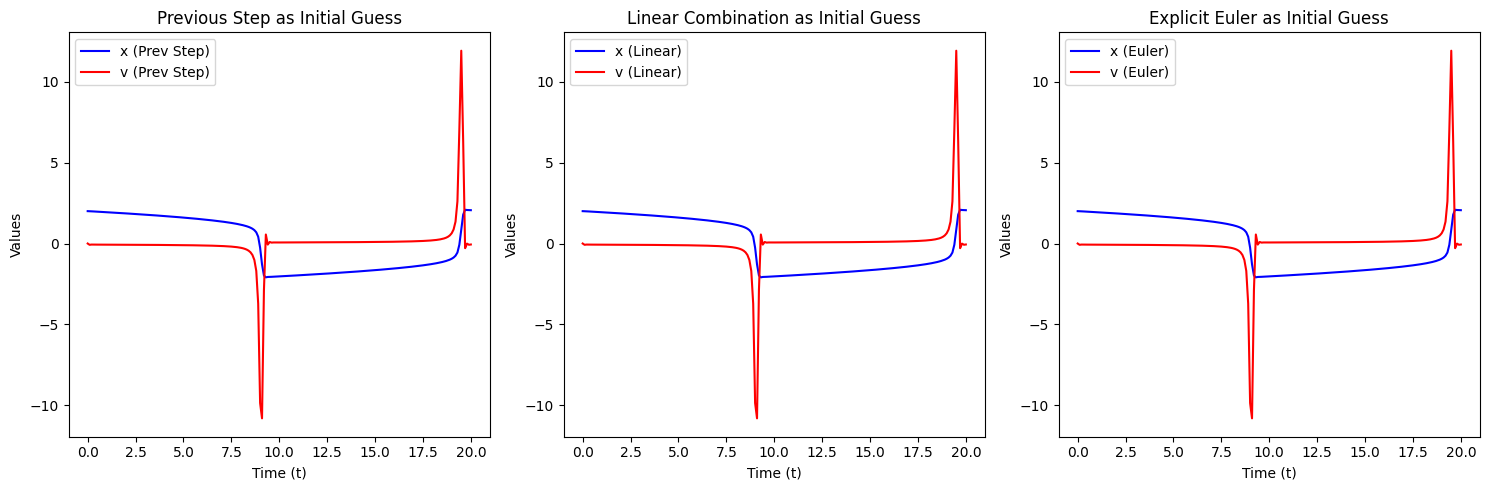

In [41]:
def newton_method(f, y0, t, dt, tol=1e-5, max_iter=100, args=(), init_guess=None):
    def g(t, y, *args):
        return y - y0 - 0.5 * dt * (f(t, y0, *args) + f(t + dt, y, *args))

    def cond_fun(carry):
        i, y1, A, df = carry
        condition = jnp.logical_or(jnp.linalg.norm(A) < tol, jnp.linalg.norm(df) < tol)
        return jnp.logical_and(i < max_iter, jnp.logical_not(condition))

    def body_fun(carry):
        i, y1, _, _ = carry
        jac_fun = jax.jacfwd(lambda y: g(t, y, *args))
        A = jac_fun(y1)
        df = g(t, y1, *args)
        new_y1 = y1 - jnp.linalg.solve(A, df)
        return (i + 1, new_y1, A, df)

    if init_guess is None:
        y1 = y0
    else:
        y1 = init_guess

    jac_fun = jax.jacfwd(lambda y: g(t, y, *args))
    A = jac_fun(y1)
    df = g(t, y1, *args)
    init_carry = (0, y1, A, df)
    _, result, _, _ = jax.lax.while_loop(cond_fun, body_fun, init_carry)
    return result

# 定义 Van der Pol 振荡器的 ODE 右侧函数
def f(t, y, mu):
    x, v = y
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return jnp.array([dxdt, dvdt])

y0 = jnp.array([2.0, 0.0])
t_start = 0.0
t_end = 20.0
dt = 0.1
num_steps = int((t_end - t_start) / dt)
t_values = jnp.linspace(t_start, t_end, num_steps + 1)
mu = 10.0  # 较大的 mu 值使问题更刚性

# 使用上一步的值作为初始猜测
y_numerical_prev = [y0]
y_current = y0
for i in range(num_steps):
    t = t_values[i]
    y_current = newton_method(f, y_current, t, dt, args=(mu,))
    y_numerical_prev.append(y_current)
y_numerical_prev = jnp.array(y_numerical_prev)

# 使用前两步值的线性组合作为初始猜测
y_numerical_linear = [y0]
y_current = y0
y_prev = y0
alpha = 0.5
for i in range(num_steps):
    t = t_values[i]
    if i > 0:
        init_guess = alpha * y_prev + (1 - alpha) * y_current
    else:
        init_guess = y_current
    y_prev = y_current
    y_current = newton_method(f, y_current, t, dt, args=(mu,), init_guess=init_guess)
    y_numerical_linear.append(y_current)
y_numerical_linear = jnp.array(y_numerical_linear)

# 使用显式欧拉法下一步的值作为初始猜测
y_numerical_euler = [y0]
y_current = y0
for i in range(num_steps):
    t = t_values[i]
    init_guess = y_current + dt * f(t, y_current, mu)
    y_current = newton_method(f, y_current, t, dt, args=(mu,), init_guess=init_guess)
    y_numerical_euler.append(y_current)
y_numerical_euler = jnp.array(y_numerical_euler)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(t_values, y_numerical_prev[:, 0], label='x (Prev Step)', color='blue')
plt.plot(t_values, y_numerical_prev[:, 1], label='v (Prev Step)', color='red')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Previous Step as Initial Guess')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(t_values, y_numerical_linear[:, 0], label='x (Linear)', color='blue')
plt.plot(t_values, y_numerical_linear[:, 1], label='v (Linear)', color='red')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Linear Combination as Initial Guess')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t_values, y_numerical_euler[:, 0], label='x (Euler)', color='blue')
plt.plot(t_values, y_numerical_euler[:, 1], label='v (Euler)', color='red')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Explicit Euler as Initial Guess')
plt.legend()

plt.tight_layout()
plt.show()